## Mission: Réaliser un algorithme de détection de la race d'un chien à partir de sa photo

### Notebook d'analyse et de prétraitement d'images. 
### Modélisation avec SIFT (sans et avec data augmentation)

## Sommaire
1. [Mission](#Mission)
2. [Librairies installées](#Librairies-installées)
3. [Dataset et propriétés intellectuelles](#Dataset-et-propriétés-intellectuelles)
   - [Nombre de races de chiens](#Nombre-de-races-de-chiens)
   - [Nombre total d'images](#Nombre-total-d'images)
   - [Extensions trouvées](#Extensions-trouvées)
4. [Dimension des images](#Dimension-des-images)
   - [Diagrammes de la hauteur, de la largeur des images](#Diagrammes-de-la-hauteur-de-la-largeur-des-images)
   - [Scatterplot des dimensions](#Scatterplot-des-dimensions)
5. [Redimensionnement](#Redimensionnement)
   - [Choix de dimensions 224x224](#Choix-de-dimensions-224x224)
6. [Autres traitements](#Autres-traitements)
   - [Floutage](#Floutage)
   - [Égalisation](#Égalisation)
7. [Extraction de Caractéristiques avec SIFT](#Extraction-de-caractéristiques-avec-SIFT)
   - [Limitation à 4 races de chiens](#Limitation-à-4-races-de-chiens)
   - [Normalisation de la Taille des Descripteurs SIFT](#Normalisation-de-la-taille-des-descripteurs-SIFT)
   - [Séparation des Données en Ensembles d'Entraînement et de Test](#Séparation-des-données)
   - [Entraînement et Évaluation d'un Modèle SVM (métrique accuracy)](Entraînement-et-Évaluation-SVM)
8. [SIFT avec Augmentation des Données d'Images](#Augmentation-des-données)
   - [Normalisation de la Taille des Descripteurs SIFT](#Normalisation-de-la-taille-des-descripteurs-SIFT-aug)
   - [Séparation des Données en Ensembles d'Entraînement et de Test](#Séparation-des-données-aug)
   - [Entraînement et Évaluation d'un Modèle SVM (métrique accuracy)](#Entraînement-et-Évaluation-SVM-aug)


## Librairies installées

TensorFlow : bibliothèque complète pour diverses tâches d'apprentissage automatique et profond. Keras, qui est une API de haut niveau pour construire et entraîner des modèles en TensorFlow, est inclus dans TensorFlow 2.x.

OpenCV (Open Source Computer Vision Library) : bibliothèque utilisée pour le traitement d'images et la vision par ordinateur. Elle est essentielle pour effectuer des opérations d'égalisation et de blanchiment des images.

os : bibliothèque utilisée pour interagir avec le système d'exploitation. Elle est utile pour manipuler les chemins de fichiers, parcourir les répertoires, etc.

numpy : bibliothèque essentielle pour le calcul scientifique en Python. Elle est particulièrement utile pour la manipulation de matrices, qui est une opération courante dans le traitement d'images.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import shutil
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import time

2024-01-03 12:01:05.803504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset et propriété intellectuelle

http://vision.stanford.edu/aditya86/ImageNetDogs/  
  
https://www.tensorflow.org/datasets/catalog/stanford_dogs?hl=fr#:~:text=Except%20as%20otherwise%20noted%2C%20the,of%20Oracle%20and%2For%20its%20affiliates  

Le contenu de la page TensorFlow Datasets, qui inclut des informations sur le Stanford Dogs Dataset, est sous licence Creative Commons Attribution 4.0. Cette licence permet généralement de partager et d'adapter l'œuvre, tant que l'attribution appropriée est donnée. Les échantillons de code sur cette page sont sous licence Apache 2.0

In [2]:
dossier = 'races_chiens'
nombre_sous_dossiers = len([nom for nom in os.listdir(dossier) if os.path.isdir(os.path.join(dossier, nom))])

print("Nombre de sous-dossiers de races de chiens :", nombre_sous_dossiers)


Nombre de sous-dossiers de races de chiens : 120


In [3]:
nombre_fichiers_total = sum(len(fichiers) for _, _, fichiers in os.walk(dossier))

print("Nombre total d'images :", nombre_fichiers_total)

Nombre total d'images : 20581


In [4]:
extensions = set()

for dossier_courant, sous_dossiers, fichiers in os.walk(dossier):
    for fichier in fichiers:
        _, ext = os.path.splitext(fichier)
        extensions.add(ext.lower())

print("Extensions de fichiers trouvées :", extensions)

Extensions de fichiers trouvées : {'', '.jpg'}


L'ensemble de données Stanford Dogs contient des images de 120 races de chiens du monde entier. Cet ensemble de données a été construit à l'aide d'images et d'annotations d'ImageNet pour la tâche de catégorisation fine des images. Il existe 20 581 images différentes.

Source Originale : Les images du Stanford Dogs Dataset proviennent de ImageNet, qui est une base de données de formation largement utilisée dans la recherche en vision par ordinateur. ImageNet recueille des images de diverses sources publiques, y compris des sites Web.

Utilisation à des Fins de Recherche : Le Stanford Dogs Dataset est destiné principalement à des fins de recherche et d'éducation. Ici ce dataset est bien utilisé dans un contexte académique et non pas de recherche commerciale.

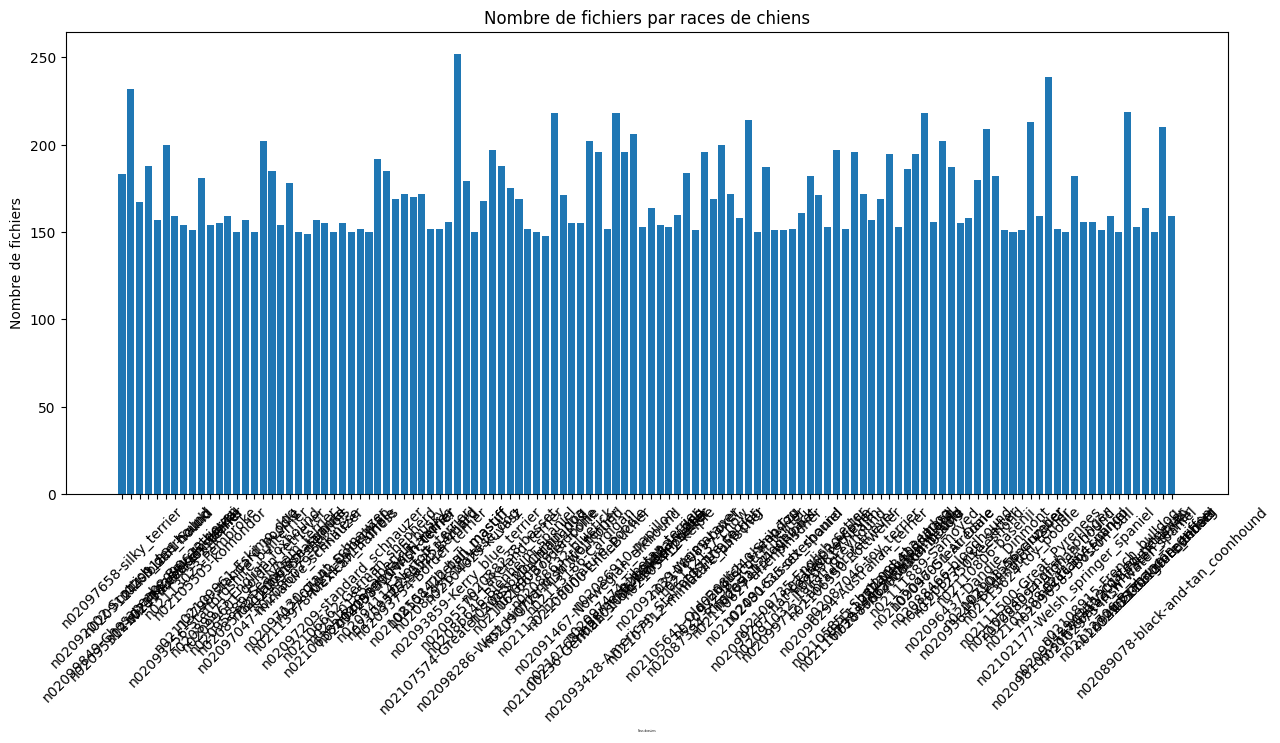

In [5]:
dossier = 'races_chiens'

# Nombre de fichiers dans chaque sous-dossier
nombre_fichiers = {nom: len(os.listdir(os.path.join(dossier, nom))) for nom in os.listdir(dossier) if os.path.isdir(os.path.join(dossier, nom))}

noms_sous_dossiers = list(nombre_fichiers.keys())

comptages = list(nombre_fichiers.values())

plt.figure(figsize=(15, 6))  
plt.bar(noms_sous_dossiers, comptages)
plt.xlabel('Sous-dossiers', fontsize=2)  
plt.xlabel('Sous-dossiers')
plt.ylabel('Nombre de fichiers')
plt.title('Nombre de fichiers par races de chiens')
plt.xticks(rotation=45)  # Faire pivoter les étiquettes si nécessaire
plt.show()

## Dimension des images

In [6]:
dossier = 'races_chiens'
largeurs, hauteurs = [], []

for sous_dossier in os.listdir(dossier):
    chemin_sous_dossier = os.path.join(dossier, sous_dossier)
    if os.path.isdir(chemin_sous_dossier):
        for fichier in os.listdir(chemin_sous_dossier):
            if fichier.endswith(('.png', '.jpg', '.jpeg')):  # Ajouter d'autres formats si nécessaire
                chemin_image = os.path.join(chemin_sous_dossier, fichier)
                with Image.open(chemin_image) as img:
                    largeur, hauteur = img.size
                    largeurs.append(largeur)
                    hauteurs.append(hauteur)

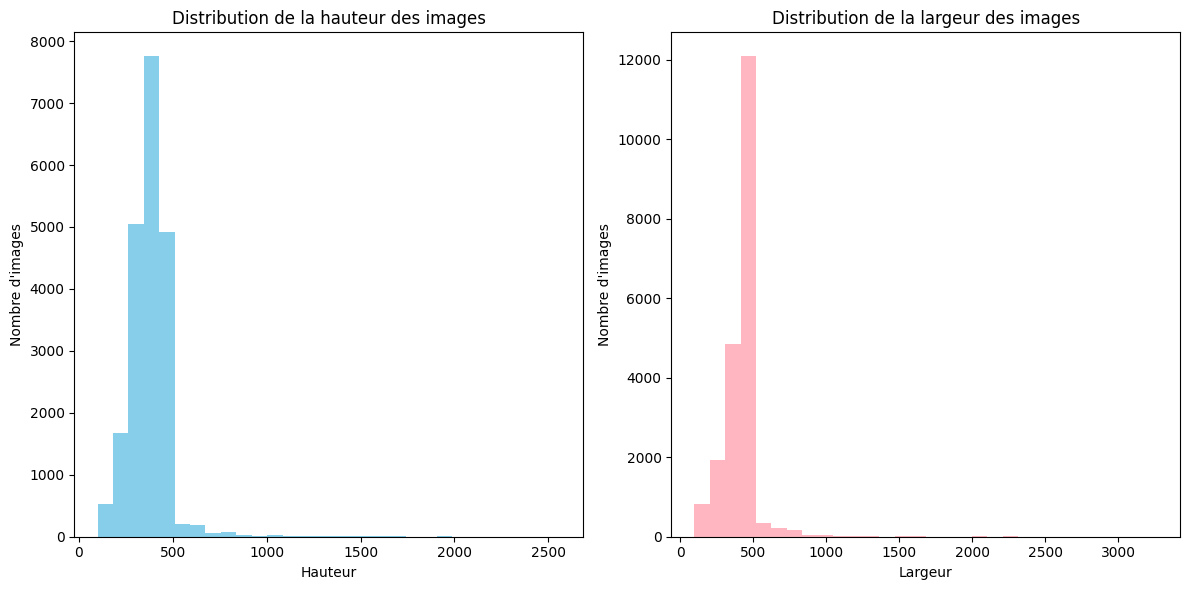

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(hauteurs, color='skyblue', bins=30)
ax1.set_title('Distribution de la hauteur des images')
ax1.set_xlabel('Hauteur')
ax1.set_ylabel('Nombre d\'images')

ax2.hist(largeurs, color='lightpink', bins=30)
ax2.set_title('Distribution de la largeur des images')
ax2.set_xlabel('Largeur')
ax2.set_ylabel('Nombre d\'images')

plt.tight_layout()
plt.show()

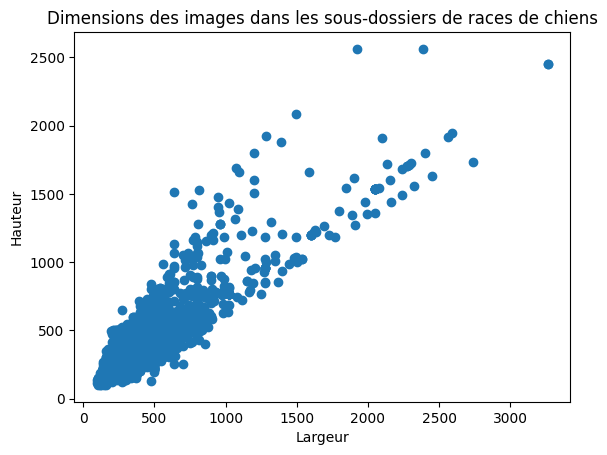

In [8]:
plt.scatter(largeurs, hauteurs)
plt.xlabel('Largeur')
plt.ylabel('Hauteur')
plt.title('Dimensions des images dans les sous-dossiers de races de chiens')
plt.show()

Les plus hautes fréquences sont pour une largeur d'image entre 400 et 500 pixels et une hauteur entre 300 et 400 pixels. Certaines images ont des dimensions allant au-delà des 2500 pixels.  


## Redimensionnement

`Pourquoi redimensionner ?`  
Les images de grande taille augmentent la complexité computationnelle, car elles contiennent plus de pixels à traiter. Redimensionner les images en dimensions plus petites réduit le nombre de calculs nécessaires, ce qui rend l'entraînement plus rapide et moins coûteux en termes de ressources.

`D'autres raisons de redimensionner pour la suite du projet (dans le cadre des réseaux de neurones convolutifs):`   
Uniformité des Entrées : Les CNN nécessitent que toutes les images en entrée aient la même taille. Redimensionner garantit cette uniformité.  
Compatibilité avec l'Architecture du Modèle : De nombreux modèles pré-entraînés et architectures de CNN populaires ont été conçus et entraînés sur des images de tailles spécifiques (par exemple, 224x224 pour VGG16 ou encore 256 x 256, 299 x 299, ou 512 x 512 pixels pour d'autres modèles comment ResNet, Inception...). Pour utiliser ces modèles avec un transfert d'apprentissage, il est important de correspondre à leur taille d'entrée attendue.  
`On utilisera VGG16 plus loin dans le projet. On redimensionnera donc ici toutes les images en 224x224 pixels.`   

In [9]:
source_dossier = 'races_chiens'
destination_dossier = 'races_chiens_224'

# Suppression du dossier de destination s'il existe
if os.path.exists(destination_dossier):
    shutil.rmtree(destination_dossier)

os.makedirs(destination_dossier, exist_ok=True)

for dossier in os.listdir(source_dossier):
    sous_dossier_source = os.path.join(source_dossier, dossier)
    
    if os.path.isdir(sous_dossier_source):
        sous_dossier_destination = os.path.join(destination_dossier, dossier)
        os.makedirs(sous_dossier_destination, exist_ok=True)

        for fichier in os.listdir(sous_dossier_source):
            fichier_source = os.path.join(sous_dossier_source, fichier)
            fichier_destination = os.path.join(sous_dossier_destination, fichier)

            image = cv2.imread(fichier_source)
            image_redimensionnee = cv2.resize(image, (224, 224))

            cv2.imwrite(fichier_destination, image_redimensionnee)


## Autres traitements
### Floutage


#### Principes
Le floutage est le processus de lissage d'une image. Il implique de moyenner les pixels avec leurs voisins à l'aide de divers filtres tels que le filtre gaussien, le filtre médian, ou le filtre bilatéral.

#### Intérêts
- **Réduction du Bruit** : Aide à réduire le bruit dans une image, améliorant ainsi la qualité avant d'autres traitements.
- **Simplification des Détails** : Facilite la détection des caractéristiques importantes en lissant les variations de pixel.
- **Prétraitement pour la Détection de Contours** : Utilisé avant la détection de contours pour minimiser les faux contours dus au bruit.


In [10]:
def appliquer_flou(image_path, save_path):
    img = cv2.imread(image_path)
    # flou gaussien
    img_floue = cv2.GaussianBlur(img, (5, 5), 0)
    cv2.imwrite(save_path, img_floue)

In [11]:
def traiter_images(source_dossier, destination_dossier, fonction_traitement):
    # si le dossier de destination existe déjà, on l'écrase
    if os.path.exists(destination_dossier):
        shutil.rmtree(destination_dossier)

    for dossier in os.listdir(source_dossier):
        sous_dossier_source = os.path.join(source_dossier, dossier)
        sous_dossier_destination = os.path.join(destination_dossier, dossier)

        if os.path.isdir(sous_dossier_source):
            os.makedirs(sous_dossier_destination, exist_ok=True)

            for fichier in os.listdir(sous_dossier_source):
                fichier_source = os.path.join(sous_dossier_source, fichier)
                fichier_destination = os.path.join(sous_dossier_destination, fichier)

                # Application de la fonction de traitement
                fonction_traitement(fichier_source, fichier_destination)


In [12]:
traiter_images('races_chiens_224', 'races_chiens_224_flou', appliquer_flou)

### Égalisation (Histogram equalization)

#### Equalization: amélioration du contraste de l'image

#### Principes
L'égalisation de l'histogramme ajuste le contraste de l'image en redistribuant l'intensité lumineuse pour étendre la gamme dynamique des niveaux de gris.

#### Intérêts
- **Amélioration du Contraste** : Particulièrement utile dans les images à faible contraste ou avec un arrière-plan et un premier plan aux luminosités similaires.
- **Meilleure Visualisation des Détails** : Révèle des détails dans les zones trop claires ou trop sombres.
- **Normalisation des Images** : Utilisée pour normaliser les images en vision par ordinateur, assurant une analyse cohérente malgré les variations de luminosité.


Conversion de l'image du format de couleur BGR (le format par défaut utilisé par OpenCV) en format YUV.  
Dans YUV, Y représente la luminance (ou le niveau de gris) de l'image, tandis que U et V représentent les chrominances (informations de couleur).  
L'égalisation d'histogramme se fait uniquement sur le canal Y de l'image YUV. L'égalisation d'histogramme améliore le contraste de l'image, mais ici, elle est appliquée uniquement sur le canal de luminance pour éviter de distordre les couleurs de l'image.

In [13]:
def appliquer_equalization(image_path, save_path):
    img = cv2.imread(image_path)

    # Égalisation de l'histogramme
    if len(img.shape) == 2 or img.shape[2] == 1:
        img_traitee = cv2.equalizeHist(img)
    else:
        # Convertir en YUV et égaliser seulement le canal Y
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        img_traitee = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    cv2.imwrite(save_path, img_traitee)

In [14]:
traiter_images('races_chiens_224_flou', 'races_chiens_224_flou_eq', appliquer_equalization)

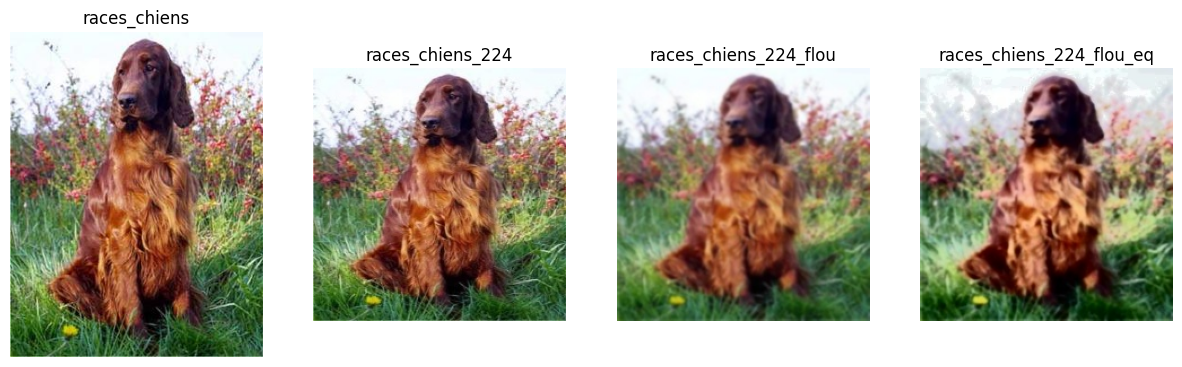

In [1]:
import os
import random
import matplotlib.pyplot as plt
import cv2

def afficher_image_aleatoire(*dossiers):
    # Sélection d'un sous-dossier et d'un fichier au hasard dans le premier dossier
    premier_dossier = dossiers[0]
    sous_dossiers = [d for d in os.listdir(premier_dossier) if os.path.isdir(os.path.join(premier_dossier, d))]
    sous_dossier_choisi = random.choice(sous_dossiers)
    fichiers = os.listdir(os.path.join(premier_dossier, sous_dossier_choisi))
    fichier_choisi = random.choice(fichiers)

    # Affichage de l'image correspondante de chaque dossier
    fig, axs = plt.subplots(1, len(dossiers), figsize=(15, 5))
    for i, dossier in enumerate(dossiers):
        chemin_image = os.path.join(dossier, sous_dossier_choisi, fichier_choisi)
        image = cv2.imread(chemin_image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV lit les images dans le format BGR
        axs[i].imshow(image)
        axs[i].set_title(f'{os.path.basename(dossier)}')
        axs[i].axis('off')
    plt.show()

# Exemple d'utilisation
afficher_image_aleatoire('races_chiens', 'races_chiens_224', 'races_chiens_224_flou', 'races_chiens_224_flou_eq')


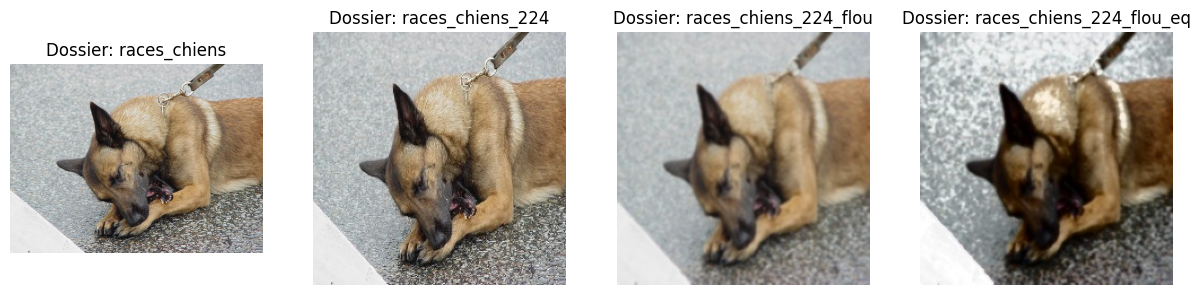

In [21]:
afficher_image_aleatoire('races_chiens', 'races_chiens_224', 'races_chiens_224_flou', 'races_chiens_224_flou_eq')

## Extraction de Caractéristiques avec SIFT<a name="Extraction-de-caractéristiques-avec-SIFT"></a>

L'algorithme SIFT (Scale-Invariant Feature Transform) est utilisé pour détecter et décrire les points d'intérêt locaux dans les images, ce qui est utile pour des tâches telles que la reconnaissance d'objets et la classification.

- **Fonction apply_sift**:
    - Elle prend en entrée le chemin d'une image et le chemin de sauvegarde.
    - L'image est d'abord lue et convertie en niveaux de gris.
    - L'algorithme SIFT est appliqué pour détecter les points clés et calculer les descripteurs.
    - Les points clés sont dessinés sur l'image originale en niveaux de gris, et l'image résultante est sauvegardée.
    - La fonction retourne les descripteurs de l'image.

- **Traitement des Images du Dossier Source**:
    - Pour chaque image, la fonction `apply_sift` est appelée, les descripteurs sont extraits et stockés dans `descriptors_list`.
    - Les labels (chemins des sous-dossiers sources) sont stockés dans `labels_list`.



In [16]:
def apply_sift(image_path, save_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    image_with_keypoints = cv2.drawKeypoints(gray_image, keypoints, image)
    cv2.imwrite(save_path, image_with_keypoints)
    return descriptors

In [ ]:
source_dossier = 'races_chiens_224_flou_eq'
destination_dossier = 'races_chiens_224_sift'

descriptors_list = []
labels_list = []

if os.path.exists(destination_dossier):
    shutil.rmtree(destination_dossier)

for dossier in os.listdir(source_dossier):
    sous_dossier_source = os.path.join(source_dossier, dossier)
    sous_dossier_destination = os.path.join(destination_dossier, dossier)

    # si le dossier existe déjà, il est supprimé pour éviter les conflits
    if os.path.isdir(sous_dossier_source):
        os.makedirs(sous_dossier_destination, exist_ok=True)

        for fichier in os.listdir(sous_dossier_source):
            fichier_source = os.path.join(sous_dossier_source, fichier)
            fichier_destination = os.path.join(sous_dossier_destination, fichier)

            # Application de la fonction de traitement
            # fonction_traitement(fichier_source, fichier_destination)
            descriptors = apply_sift(fichier_source, fichier_destination)
            if descriptors is not None:
                descriptors_list.append(descriptors.flatten())
                labels_list.append(sous_dossier_source)

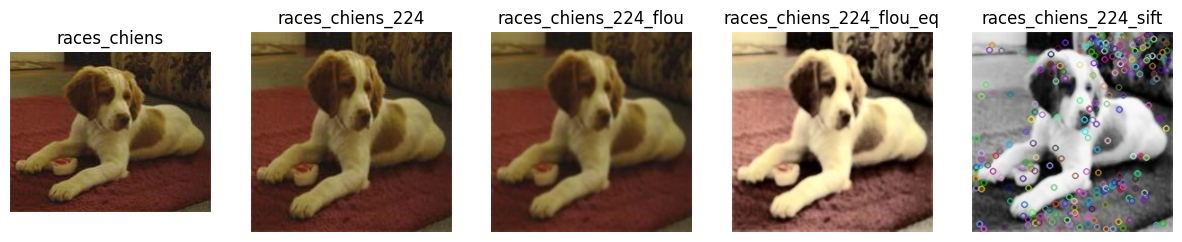

In [13]:
afficher_image_aleatoire('races_chiens', 'races_chiens_224', 'races_chiens_224_flou', 'races_chiens_224_flou_eq', 'races_chiens_224_sift')

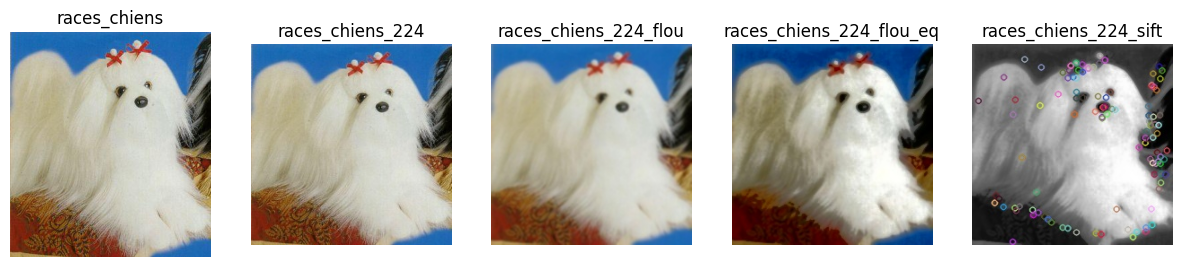

In [3]:
afficher_image_aleatoire('races_chiens', 'races_chiens_224', 'races_chiens_224_flou', 'races_chiens_224_flou_eq', 'races_chiens_224_sift')

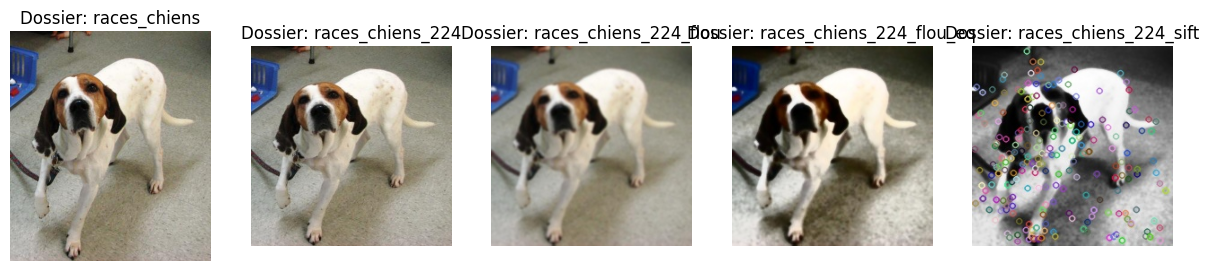

In [69]:
afficher_image_aleatoire('races_chiens', 'races_chiens_224', 'races_chiens_224_flou', 'races_chiens_224_flou_eq', 'races_chiens_224_sift')

### Limitation à 4 races de chiens

`Pour utiliser le SIFT, on se limitera à un dataset avec seulement 4 races de chiens afin de ne pas avoir un temps d'exécution trop long du modèle.`


In [17]:
# source_dossier = 'races_chiens_224_flou_eq'
# destination_dossier = 'races_chiens_224_sift'

source_dossier = 'races_chiens_4_224_flou_eq'
destination_dossier = 'races_chiens_4_224_sift'

descriptors_list = []
labels_list = []

if os.path.exists(destination_dossier):
    shutil.rmtree(destination_dossier)

for dossier in os.listdir(source_dossier):
    sous_dossier_source = os.path.join(source_dossier, dossier)
    sous_dossier_destination = os.path.join(destination_dossier, dossier)

    # si le dossier existe déjà, il est supprimé pour éviter les conflits
    if os.path.isdir(sous_dossier_source):
        os.makedirs(sous_dossier_destination, exist_ok=True)

        for fichier in os.listdir(sous_dossier_source):
            fichier_source = os.path.join(sous_dossier_source, fichier)
            fichier_destination = os.path.join(sous_dossier_destination, fichier)

            # Application de la fonction de traitement
            # fonction_traitement(fichier_source, fichier_destination)
            descriptors = apply_sift(fichier_source, fichier_destination)
            if descriptors is not None:
                descriptors_list.append(descriptors.flatten())
                labels_list.append(sous_dossier_source)

In [22]:
descriptors_list

[array([127.,  57.,   0., ...,   0.,   0.,   0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([93.,  2.,  0., ..., 15., 47., 69.], dtype=float32),
 array([ 8., 17.,  8., ..., 99., 46.,  5.], dtype=float32),
 array([1., 0., 2., ..., 3., 2., 7.], dtype=float32),
 array([9., 2., 0., ..., 0., 5., 7.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([56.,  3.,  0., ...,  4.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0., ...,  3.,  3., 59.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([26., 12., 15., ...,  0., 20., 19.], dtype=float32),
 array([0., 0., 0., ..., 7., 1., 1.], dtype=float32),
 array([10., 34., 89., ...,  0.,  0.,  4.], dtype=float32),
 array([37., 17., 73., ..., 13.,  5.,  4.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([ 0.,  2.,  5., ..., 51.,  3.,  3.], dtype=float32),
 array([1., 0., 0., ..

In [23]:
for descriptor in descriptors_list:
    print(descriptor.shape)

(48256,)
(63104,)
(45056,)
(27392,)
(29184,)
(51200,)
(40064,)
(28416,)
(129536,)
(32768,)
(40576,)
(60032,)
(61056,)
(94976,)
(35840,)
(94848,)
(52992,)
(35584,)
(29568,)
(58496,)
(53888,)
(56320,)
(34944,)
(46848,)
(28160,)
(55040,)
(62976,)
(152960,)
(60544,)
(36096,)
(51968,)
(85120,)
(20352,)
(34432,)
(74112,)
(142336,)
(128768,)
(62592,)
(19072,)
(33792,)
(43392,)
(105088,)
(89472,)
(32256,)
(54400,)
(162816,)
(41984,)
(96000,)
(61568,)
(112256,)
(52992,)
(59776,)
(60288,)
(52096,)
(81920,)
(39040,)
(35584,)
(41216,)
(37888,)
(75008,)
(97408,)
(38144,)
(28672,)
(14464,)
(94464,)
(131200,)
(20480,)
(84480,)
(62208,)
(226176,)
(47744,)
(108544,)
(35712,)
(53504,)
(26880,)
(103552,)
(31104,)
(45568,)
(35328,)
(60032,)
(27648,)
(44544,)
(18688,)
(42624,)
(43392,)
(24448,)
(134400,)
(38016,)
(24832,)
(27264,)
(31488,)
(22656,)
(75136,)
(128256,)
(66688,)
(29312,)
(55040,)
(44160,)
(44544,)
(56320,)
(61312,)
(34560,)
(69632,)
(123648,)
(28160,)
(25600,)
(82688,)
(59648,)
(86272,)
(5772

### Normalisation de la Taille des Descripteurs SIFT<a name="Normalisation-de-la-taille-des-descripteurs-SIFT"></a>

La normalisation est cruciale pour garantir que tous les descripteurs aient une taille uniforme, ce qui est nécessaire pour les utiliser efficacement dans les algorithmes de classification ou de regroupement.

- **Calcul de la Taille Médiane**:
    - `median_size` est calculée comme la taille médiane des descripteurs dans `descriptors_list`. Cela détermine la taille cible pour ajuster tous les autres descripteurs.

- **Fonction adjust_descriptors**:
    - Pour chaque descripteur, la fonction ajuste sa taille à `target_size`. Si le descripteur est plus long que la taille cible, il est tronqué. S'il est plus court, il est étendu avec des zéros.
    - Le résultat est une liste de descripteurs ajustés, tous ayant la même longueur.



In [24]:
# Calcul de la taille médiane
median_size = int(np.median([d.shape[0] for d in descriptors_list]))

# Calcul du 75e percentile
percentile_75_size = int(np.percentile([d.shape[0] for d in descriptors_list], 75))

print("Taille médiane:", median_size)
print("Taille du 75e percentile:", percentile_75_size)


Taille médiane: 47424
Taille du 75e percentile: 76480


In [25]:
def adjust_descriptors(descriptors, target_size):
    """
    Ajuste la taille des descripteurs pour qu'ils aient tous la longueur target_size.
    Si un descripteur est plus long que target_size, il est tronqué.
    Si un descripteur est plus court, il est étendu avec des zéros.
    
    :param descriptors: Liste des descripteurs (chaque descripteur est un tableau numpy).
    :param target_size: La taille cible pour chaque descripteur.
    :return: Liste des descripteurs ajustés.
    """
    adjusted_descriptors = []

    for desc in descriptors:
        if len(desc) > target_size:
            # Tronquer le descripteur
            adjusted_desc = desc[:target_size]
        elif len(desc) < target_size:
            # Étendre le descripteur avec des zéros
            adjusted_desc = np.pad(desc, (0, target_size - len(desc)), 'constant')
        else:
            adjusted_desc = desc
        adjusted_descriptors.append(adjusted_desc)

    return adjusted_descriptors


In [26]:
target_size = median_size  
adjusted_descriptors_list = adjust_descriptors(descriptors_list, target_size)

### Séparation des Données en Ensembles d'Entraînement et de Test<a name="Séparation-des-données"></a>


In [27]:
X_train, X_test, y_train, y_test = train_test_split(adjusted_descriptors_list, labels_list, test_size=0.2)

### Entraînement et Évaluation d'un Modèle SVM<a name="Entraînement-et-Évaluation-SVM"></a>

Ce code configure et évalue un modèle de machine learning basé sur une machine à vecteurs de support (SVM) pour la classification des images.

- **Normalisation des Descripteurs**:
    - Avant l'entraînement, les descripteurs sont normalisés en utilisant `StandardScaler`. Cela garantit que les caractéristiques sont sur une échelle comparable, améliorant ainsi les performances du modèle SVM.

- **Entraînement du Modèle SVM**:
    - Un modèle SVM avec un noyau linéaire (`SVC(kernel='linear')`) est entraîné sur l'ensemble d'entraînement normalisé.

- **Prédiction et Évaluation**:
    - Le modèle est utilisé pour faire des prédictions sur l'ensemble de test.
    - `classification_report` et `confusion_matrix` de scikit-learn sont utilisés pour évaluer les performances du modèle, fournissant des métriques telles que la précision, le rappel et le score F1, ainsi qu'une matrice de confusion.


#### Métrique accuracy, matrice de confusion, temps d'entraînement

Si les classes étaient fortement déséquilibrées, des métriques comme le rappel (recall), le score F1 ou l'aire sous la courbe ROC (AUC-ROC) pourraient fournir une évaluation nuancée de la performance du modèle, mais on a vu que précédemment que le dataset de races de chiens étaient fourni de manière équilibrée.  
Les classes étant équilibrées, `l'accuracy est ici adpatée comme métrique de performance, d'autant plus que c'est une mesure simple et intuitive: elle représente le pourcentage de prédictions correctes parmi l'ensemble des prédictions faites.`   
La matrice de confusion aussi sera représentée, elle est une bonne synthèse de comparaison entre les classes prédites et les classes réelles.  
De même on calculera le temps d'entraînement du modèle qui, s'il est trop long, peut pénaliser un modèle avec une accuracy à peine meilleure qu'un modèle beaucoup plus rapide. 

In [28]:
# Normalisation des descripteurs 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

start_time = time.time()

# Entraînement du modèle SVM
model = SVC(kernel='linear') 
model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Temps d'entraînement : {elapsed_time} secondes")

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Temps d'entraînement : 5.909965991973877 secondes
                                                       precision    recall  f1-score   support

races_chiens_4_224_flou_eq/n02099601-golden_retriever       0.15      0.17      0.16        24
  races_chiens_4_224_flou_eq/n02102318-cocker_spaniel       0.38      0.33      0.35        36
  races_chiens_4_224_flou_eq/n02108915-French_bulldog       0.10      0.05      0.07        39
   races_chiens_4_224_flou_eq/n02109525-Saint_Bernard       0.24      0.41      0.30        29

                                             accuracy                           0.23       128
                                            macro avg       0.22      0.24      0.22       128
                                         weighted avg       0.22      0.23      0.22       128

[[ 4  9  5  6]
 [ 7 12  7 10]
 [ 7  8  2 22]
 [ 8  3  6 12]]


Chaque ligne de la matrice de confusion représente les instances d'une classe réelle, et chaque colonne représente les instances d'une classe prédite. Les numéros correspondent aux classes suivantes :

`1 : Golden Retriever` 

`2 : Cocker Spaniel` 

`3 : French Bulldog` 

`4 : Saint Bernard` 

Par exemple pour la 1ère ligne, pour les Golden Retriever, le modèle a correctement prédit 6 Golden Retrievers. Les autres nombres correspondent aux prédictions incorrectes des Golden Retriever: 10 ont été vus comme des Cocker Spaniel, 7 comme des Bouledogues Français, 10 comme des Saint-Bernard.

## SIFT avec Augmentation des Données d'Images<a name="Augmentation-des-données"></a>

L'augmentation des données enrichit le dataset avec de nouvelles variantes d'images. C'est une technique courante pour améliorer les performances des modèles de deep learning, en particulier dans les scénarios de vision par ordinateur. Cela permet d'avoir un dataset plus diversifié et peut aider à prévenir l'ovefitting.

- **Paramétrage de l'Augmentation**:
    - `ImageDataGenerator` de Keras est configuré avec divers paramètres d'augmentation, tels que la rotation, le décalage, le cisaillement, le zoom et le retournement horizontal des images.

In [29]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [30]:
source_folder = 'races_chiens_4_224_flou_eq'
augmented_folder = 'races_chiens_4_224_flou_eq_aug'

if os.path.exists(augmented_folder):
    shutil.rmtree(augmented_folder)

for class_folder in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_folder)
    if os.path.isdir(class_path):
        augmented_class_folder = os.path.join(augmented_folder, class_folder)
        os.makedirs(augmented_class_folder, exist_ok=True)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir en RGB
            image = image.reshape((1,) + image.shape)  # Reshape pour le générateur

            # Générer des images augmentées
            i = 0
            for batch in data_gen.flow(image, batch_size=1, save_to_dir=augmented_class_folder, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i > 5:  # Nombre d'images augmentées à générer par image originale
                    break

In [31]:
source_dossier = 'races_chiens_4_224_flou_eq_aug'
destination_dossier = 'races_chiens_4_224_sift_aug'

descriptors_list = []
labels_list = []

if os.path.exists(destination_dossier):
    shutil.rmtree(destination_dossier)

for dossier in os.listdir(source_dossier):
    sous_dossier_source = os.path.join(source_dossier, dossier)
    sous_dossier_destination = os.path.join(destination_dossier, dossier)

    if os.path.isdir(sous_dossier_source):
        os.makedirs(sous_dossier_destination, exist_ok=True)

        for fichier in os.listdir(sous_dossier_source):
            fichier_source = os.path.join(sous_dossier_source, fichier)
            fichier_destination = os.path.join(sous_dossier_destination, fichier)

            # Application de la fonction de traitement
            # fonction_traitement(fichier_source, fichier_destination)
            descriptors = apply_sift(fichier_source, fichier_destination)
            if descriptors is not None:
                descriptors_list.append(descriptors.flatten())
                labels_list.append(sous_dossier_source)

### Normalisation de la Taille des Descripteurs SIFT<a name="Normalisation-de-la-taille-des-descripteurs-SIFT-aug"></a>



In [32]:
for descriptor in descriptors_list:
    print(descriptor.shape)

(39040,)
(48768,)
(29824,)
(39552,)
(25984,)
(19200,)
(45568,)
(35456,)
(49408,)
(35840,)
(34432,)
(30464,)
(28416,)
(41728,)
(24576,)
(28032,)
(25600,)
(22016,)
(19712,)
(97408,)
(20096,)
(24960,)
(200320,)
(102656,)
(37888,)
(67584,)
(21632,)
(51200,)
(70400,)
(24448,)
(15104,)
(42496,)
(49152,)
(69376,)
(21504,)
(45440,)
(32000,)
(10752,)
(69632,)
(20864,)
(117248,)
(41856,)
(30080,)
(16512,)
(30592,)
(50944,)
(29568,)
(22528,)
(18048,)
(49792,)
(94720,)
(45312,)
(54528,)
(67840,)
(31872,)
(25984,)
(40192,)
(34432,)
(42496,)
(16000,)
(32768,)
(36480,)
(40576,)
(23808,)
(33536,)
(35072,)
(55936,)
(24448,)
(93696,)
(20736,)
(22912,)
(53632,)
(53120,)
(58880,)
(69120,)
(73856,)
(19200,)
(91392,)
(30336,)
(39680,)
(49792,)
(33024,)
(111104,)
(29312,)
(38912,)
(41216,)
(35712,)
(23552,)
(29056,)
(34560,)
(35456,)
(58752,)
(23552,)
(45056,)
(97280,)
(23808,)
(24576,)
(119552,)
(32512,)
(38528,)
(74752,)
(27264,)
(35584,)
(117632,)
(28416,)
(39808,)
(11136,)
(23040,)
(41216,)
(23936,)
(198

In [33]:
# Calcul de la taille médiane
median_size = int(np.median([d.shape[0] for d in descriptors_list]))

# Calcul du 75e percentile
percentile_75_size = int(np.percentile([d.shape[0] for d in descriptors_list], 75))

print("Taille médiane:", median_size)
print("Taille du 75e percentile:", percentile_75_size)


Taille médiane: 35712
Taille du 75e percentile: 54208


In [34]:
target_size = 46336  # Vous pouvez définir cela selon votre besoin
adjusted_descriptors_list = adjust_descriptors(descriptors_list, target_size)


### Séparation des Données en Ensembles d'Entraînement et de Test<a name="Séparation-des-données-aug"></a>


In [35]:
X_train, X_test, y_train, y_test = train_test_split(adjusted_descriptors_list, labels_list, test_size=0.2)

### Entraînement et Évaluation d'un Modèle SVM<a name="Entraînement-et-Évaluation-SVM-aug"></a>


In [36]:
# Normalisation des descripteurs 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

start_time = time.time()

# Entraînement du modèle SVM
model = SVC(kernel='linear') 
model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Temps d'entraînement : {elapsed_time} secondes")

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Temps d'entraînement : 279.9846031665802 secondes
                                                           precision    recall  f1-score   support

races_chiens_4_224_flou_eq_aug/n02099601-golden_retriever       0.25      0.31      0.28       153
  races_chiens_4_224_flou_eq_aug/n02102318-cocker_spaniel       0.39      0.34      0.37       214
  races_chiens_4_224_flou_eq_aug/n02108915-French_bulldog       0.29      0.30      0.29       177
   races_chiens_4_224_flou_eq_aug/n02109525-Saint_Bernard       0.41      0.39      0.40       189

                                                 accuracy                           0.34       733
                                                macro avg       0.34      0.33      0.33       733
                                             weighted avg       0.34      0.34      0.34       733

[[47 32 38 36]
 [58 73 52 31]
 [41 45 53 38]
 [40 35 41 73]]


Rappel des numéros des classes pour la matrice de confusion :

`1 : Golden Retriever` 

`2 : Cocker Spaniel` 

`3 : French Bulldog` 

`4 : Saint Bernard` 

Pour les Golden Retriever (1ère ligne), le modèle a correctement prédit 47 Golden Retrievers. Les autres nombres correspondent aux prédictions incorrectes des Golden Retriever, 32 ont été vus comme des Cocker Spaniel, 38 comme des Bouledogues Français, 36 comme des Saint-Bernard.

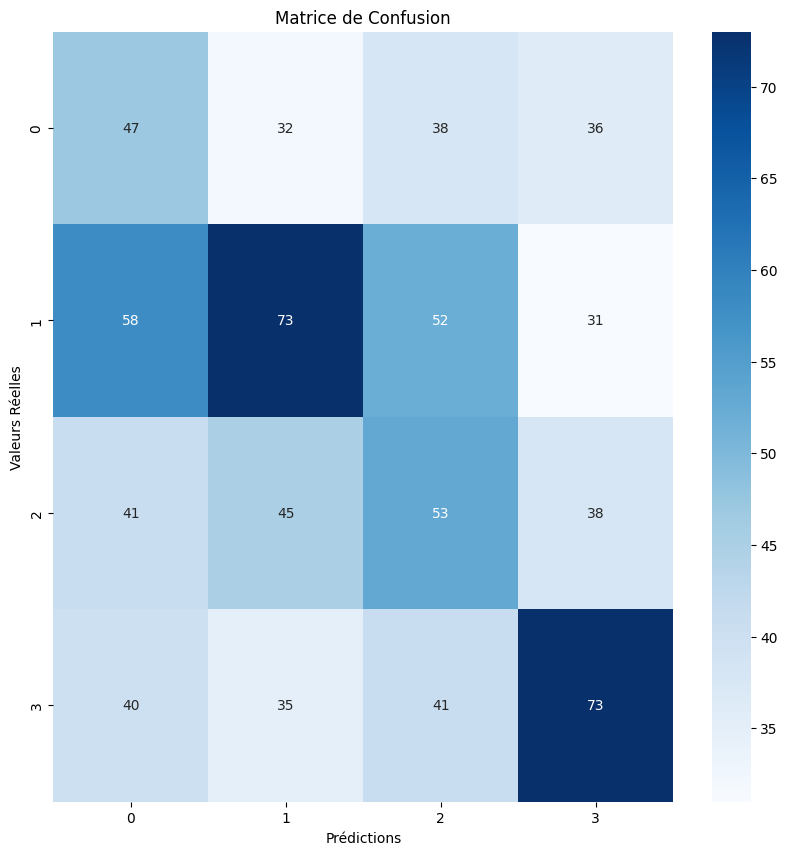

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()


L'accuracy est meilleure avec la data augmentation. (0,34 contre 0,23).
Cependant le temps d'entraînement est passé de 6 secondes à quasiment 5 minutes.  
Pour poursuivre notre étude, nous allons à présent créer notre propre modèle de réseau de neurones convolutifs pour 4 races de chiens.  
Nous allons ensuite le tester pour 12 races de chiens, et le comparer à un modèle existant pré-entraîné avec la méthode Transfer Learning pour ces mêmes 12 races de chiens.